# ***Atelier : Prédiction floue du risque de panne d’une machine industrielle***

In [66]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

***Modélisation floue:***

In [67]:
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'Temperature')
vibration = ctrl.Antecedent(np.arange(0, 11, 1), 'Vibration')
age = ctrl.Antecedent(np.arange(0, 21, 1), 'Age')
risque = ctrl.Consequent(np.arange(0, 11, 1), 'Risque')

In [68]:
temperature['basse'] = fuzz.trimf(temperature.universe, [0, 0, 40])
temperature['normale'] = fuzz.trimf(temperature.universe, [30, 50, 70])
temperature['elevee'] = fuzz.trimf(temperature.universe, [60, 100, 100])

vibration['faible'] = fuzz.trimf(vibration.universe, [0, 0, 4])
vibration['moyenne'] = fuzz.trimf(vibration.universe, [2, 5, 8])
vibration['forte'] = fuzz.trimf(vibration.universe, [6, 10, 10])

age['neuf'] = fuzz.trimf(age.universe, [0, 0, 7])
age['moyen'] = fuzz.trimf(age.universe, [5, 10, 15])
age['ancien'] = fuzz.trimf(age.universe, [12, 20, 20])

risque['faible'] = fuzz.trimf(risque.universe, [0, 0, 4])
risque['moyen'] = fuzz.trimf(risque.universe, [2, 5, 8])
risque['eleve'] = fuzz.trimf(risque.universe, [6, 10, 10])

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1000x600 with 0 Axes>

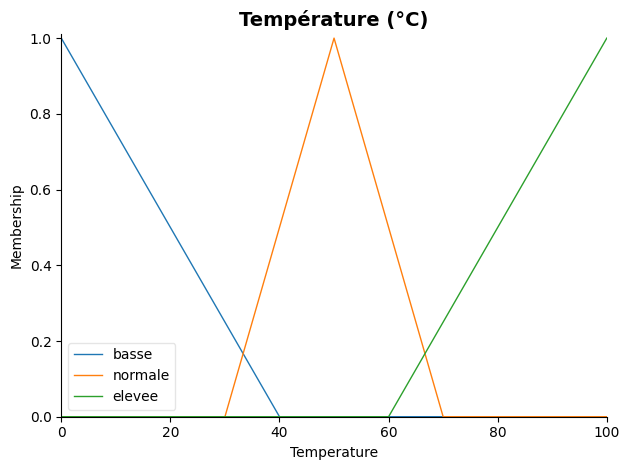

<Figure size 1000x600 with 0 Axes>

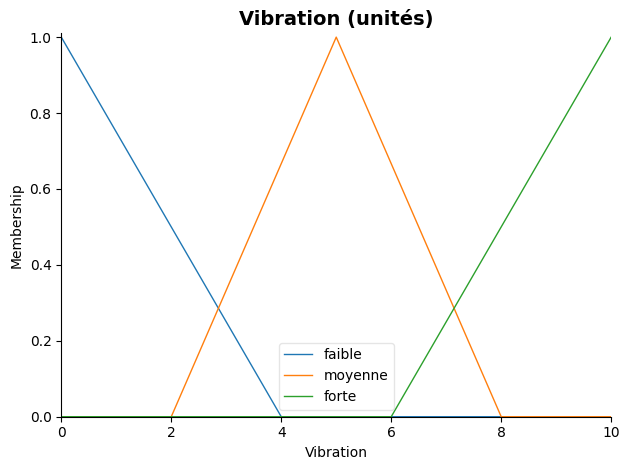

<Figure size 1000x600 with 0 Axes>

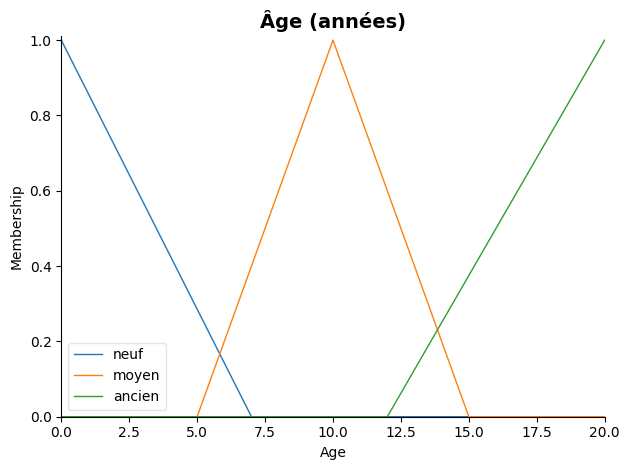

<Figure size 1000x600 with 0 Axes>

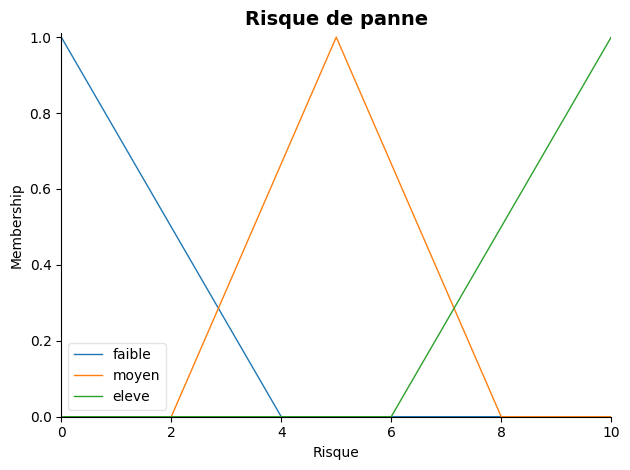

In [69]:
plt.figure(figsize=(10, 6))
temperature.view()
plt.title("Température (°C)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
vibration.view()
plt.title("Vibration (unités)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
age.view()
plt.title("Âge (années)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
risque.view()
plt.title("Risque de panne", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [70]:
rule1 = ctrl.Rule(temperature['elevee'] | vibration['forte'], risque['eleve'])
rule2 = ctrl.Rule(age['ancien'] & vibration['moyenne'], risque['moyen'])
rule3 = ctrl.Rule(temperature['basse'] & vibration['faible'] & age['neuf'], risque['faible'])
rule4 = ctrl.Rule(temperature['normale'] & age['moyen'], risque['moyen'])

In [71]:
risque_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
risque_sim = ctrl.ControlSystemSimulation(risque_ctrl)

Température: 70°C
Vibration: 6
Âge: 15 ans

Risque prédit : 5.951167728237792/10


<Figure size 1000x600 with 0 Axes>

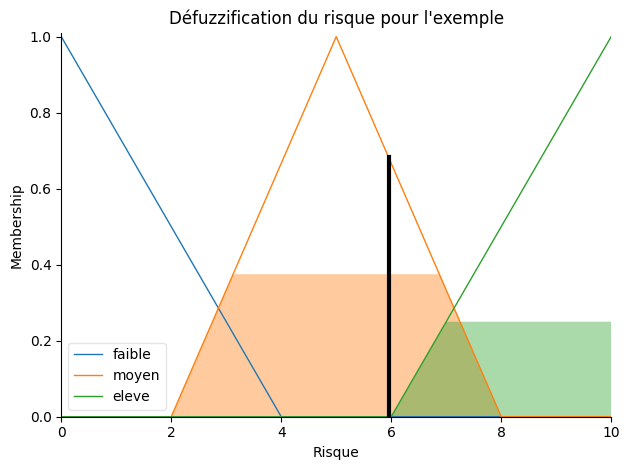

In [72]:
exemple_temp = 70
exemple_vib = 6
exemple_age = 15

risque_sim.input['Temperature'] = exemple_temp
risque_sim.input['Vibration'] = exemple_vib
risque_sim.input['Age'] = exemple_age
risque_sim.compute()

print(f"Température: {exemple_temp}°C")
print(f"Vibration: {exemple_vib}")
print(f"Âge: {exemple_age} ans")
print(f"\nRisque prédit : {risque_sim.output['Risque']}/10")

fig = plt.figure(figsize=(10, 6))
risque.view(sim=risque_sim)
plt.title("Défuzzification du risque pour l'exemple")
plt.tight_layout()
plt.show()

***Machine Learning:***

In [73]:
n = 2000

np.random.seed(42)
temp_vals = np.random.uniform(0, 100, n)
vib_vals = np.random.uniform(0, 10, n)
age_vals = np.random.uniform(0, 20, n)
risque_vals = []
for i in range(n):
    risque_sim.input['Temperature'] = float(temp_vals[i])
    risque_sim.input['Vibration'] = float(vib_vals[i])
    risque_sim.input['Age'] = float(age_vals[i])
    
    try:
        risque_sim.compute()
        risque_vals.append(risque_sim.output['Risque'])
    except:
        risque_vals.append(5.0)
X = np.column_stack((temp_vals, vib_vals, age_vals))
y = np.array(risque_vals)

print(X.shape)
print(y.mean())

(2000, 3)
6.549198184422432


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [75]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("MSE :", mse)
print("RMSE :", rmse)
print("R² :", r2)

MAE : 0.06173871918462117
MSE : 0.020799551933809016
RMSE : 0.14422049762016845
R² : 0.9945447538588553


***Interprétation et Analyse***

In [76]:
exemple_temp = 70
exemple_vib = 6
exemple_age = 15

X_exemple = np.array([[exemple_temp, exemple_vib, exemple_age]])
risque_ml = model.predict(X_exemple)[0]

print(risque_ml)

6.196345011307332


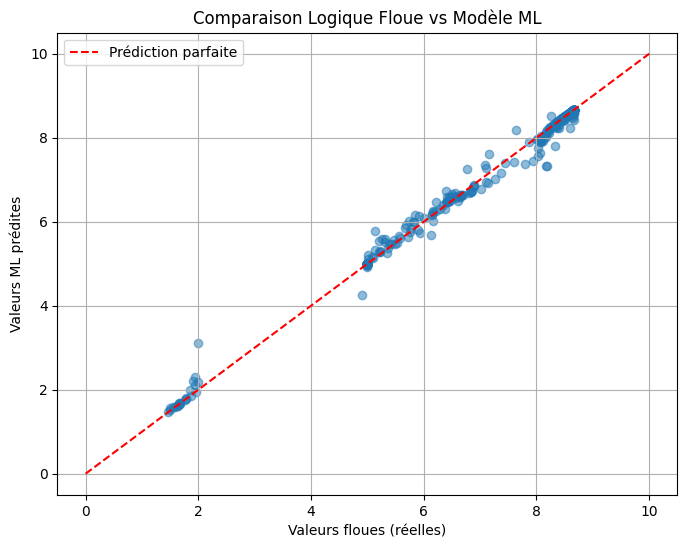

In [77]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--', label='Prédiction parfaite')
plt.xlabel("Valeurs floues (réelles)")
plt.ylabel("Valeurs ML prédites")
plt.title("Comparaison Logique Floue vs Modèle ML")
plt.legend()
plt.grid(True)
plt.show()

# Comparaison : Logique Floue vs Machine Learning

## Avantages de la Logique Floue
- **Compréhension facile** : Les règles sont comme du langage humain
- **Transparent** : On voit exactement pourquoi une décision est prise

## Avantages du Machine Learning  
- **Plus précis** : Donne généralement de meilleurs résultats numériques
- **Apprend tout seul** : Découvre des patterns complexes sans aide humaine